In [48]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# image read
image_bgr = cv2.imread('../../data/imgs/0618.png')
image_rgb = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)

# mask read
mask = cv2.imread('../../data/imgs/mask0618.png',cv2.IMREAD_GRAYSCALE)
Y = mask.flatten()
Y = np.where(Y > 128, 1, 0) # 1 road, 0 not-road


In [49]:
# pixel to pixel_block
block_size = 5
def gaussian_kernel(size, sigma=1):
    """生成高斯滤波器"""
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    return g / g.sum()
# 生成3x3的高斯滤波器
gaussian_3x3 = gaussian_kernel(5, sigma=1)

kernels = [
    gaussian_3x3,  # 高斯滤波器
    # np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32),  # Sobel X
    # np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)   # Sobel Y
]

# image size
height, width, _ = image_rgb.shape

features = []
labels = []

# 遍历图像中的每个块
for i in range(0, height - block_size + 1, 1):
    for j in range(0, width - block_size + 1, 1):
        # 获取块数据
        block = image_rgb[i:i+block_size, j:j+block_size]

        # 初始化特征向量
        feature_vector = []

        # 应用卷积核到不同的颜色空间
        for color_space in ['RGB', 'HSV', 'LAB']:
            if color_space == 'RGB':
                block_color = block
            elif color_space == 'HSV':
                block_color = cv2.cvtColor(block, cv2.COLOR_RGB2HSV)
            elif color_space == 'LAB':
                block_color = cv2.cvtColor(block, cv2.COLOR_RGB2LAB)

            for kernel in kernels:
                for channel in range(block_color.shape[2]):
                    # 对每个通道应用卷积核
                    conv_result = cv2.filter2D(block_color[:,:,channel], -1, kernel)
                    # 将卷积结果的平均值添加到特征向量中
                    feature_vector.append(np.mean(conv_result))

        # 提取标签
        block_mask = mask[i:i+block_size, j:j+block_size].flatten()
        # 如果块内超过一半的像素被标记，则该块标记为1，否则为0
        label = 1 if mask[i+block_size//2,j+block_size//2] > 0.5 else 0
        # label = 1 if np.sum(block_mask) > (block_size * block_size / 2) else 0

        features.append(feature_vector)
        labels.append(label)


# for i in range(0, height - block_size + 1, 1):
#     for j in range(0, width - block_size + 1, 1):
#         # get block data
#         block = image_rgb[i:i+block_size, j:j+block_size]

#         # extract features
#         # Calculate the mean of rgb
#         mean_rgb = np.mean(block,axis=(0, 1))
#         # Calculate the variance of rgb
#         var_rgb = np.var(block,axis=(0, 1))

#         # hsv
#         block_hsv = cv2.cvtColor(block, cv2.COLOR_RGB2HSV)

#         # mean hsv
#         mean_hsv = np.mean(block_hsv, axis=(0, 1))
#         # variance hsv
#         var_hsv = np.var(block_hsv, axis=(0, 1))
#         # LAB
#         block_lab = cv2.cvtColor(block, cv2.COLOR_RGB2LAB)
#         mean_lab = np.mean(block_lab, axis=(0, 1))
#         var_lab = np.var(block_lab, axis=(0, 1))

#         # features is size 6 vector
#         feature_vector = np.concatenate([mean_rgb, var_rgb, mean_hsv, var_hsv, mean_lab, var_lab])
#         # extract labels
#         block_mask = mask[i:i+block_size, j:j+block_size].flatten()
#         # pixel only 0 or 1,so just /2 can calculate the E(average)
#         # noise avoid ?
#         label = 1 if np.sum(block_mask) > (block_size * block_size / 2) else 0
#         # no noise avoid
#         # label = mask[i+block_size//2, j+block_size//2]
#         features.append(feature_vector)
#         labels.append(label)

In [50]:

X = np.array(features)
y = np.array(labels)


In [51]:
X.shape

(122016, 9)

In [52]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
# cross verify
cv_scores = cross_val_score(gnb, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))


y_pred = gnb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))




Cross-validation scores: [0.98324045 0.9781994  0.98438717 0.97053641 0.9690202 ]
Average cross-validation score: 0.9770767263004354
Accuracy: 0.9763563350270448
Confusion Matrix:
 [[ 9466   342]
 [  235 14361]]


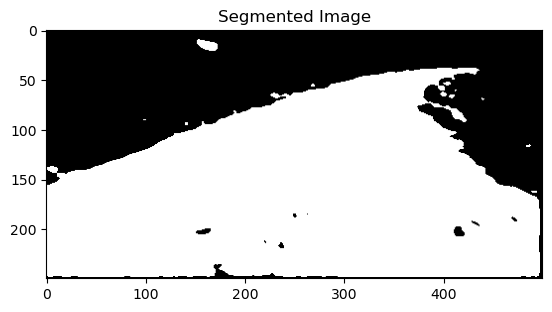

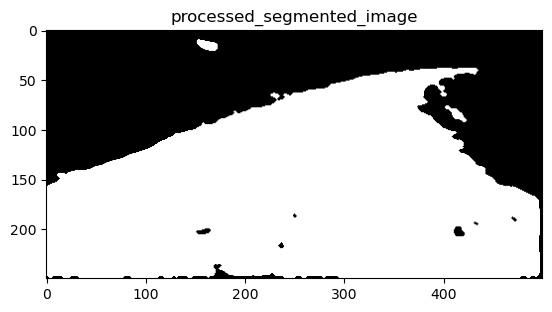

In [53]:

# use model to split the image
def segment_image(image, model, scaler, block_size=5):
    height, width, _ = image.shape
    segmented_image = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            # Ensure that the border is not exceeded
            top = max(0, i - block_size // 2)
            bottom = min(height, i + block_size // 2 + 1)
            left = max(0, j - block_size // 2)
            right = min(width, j + block_size // 2 + 1)
            
            # extract data
            block = image[top:bottom, left:right]
            # 获取块数据
            block = image_rgb[i:i+block_size, j:j+block_size]

            # 初始化特征向量
            feature_vector = []

            # 应用卷积核到不同的颜色空间
            for color_space in ['RGB', 'HSV', 'LAB']:
                if color_space == 'RGB':
                    block_color = block
                elif color_space == 'HSV':
                    block_color = cv2.cvtColor(block, cv2.COLOR_RGB2HSV)
                elif color_space == 'LAB':
                    block_color = cv2.cvtColor(block, cv2.COLOR_RGB2LAB)

                for kernel in kernels:
                    for channel in range(block_color.shape[2]):
                        # 对每个通道应用卷积核
                        conv_result = cv2.filter2D(block_color[:,:,channel], -1, kernel)
                        # 将卷积结果的平均值添加到特征向量中
                        feature_vector.append(np.mean(conv_result))

            # # extract feature
            # mean_rgb = np.mean(block, axis=(0, 1))
            # var_rgb = np.var(block, axis=(0, 1))

            # # to hsv
            # block_hsv = cv2.cvtColor(block, cv2.COLOR_RGB2HSV)

            # # hsv mean
            # mean_hsv = np.mean(block_hsv, axis=(0, 1))
            # # hsv variance
            # var_hsv = np.var(block_hsv, axis=(0, 1))

            # block_lab = cv2.cvtColor(block, cv2.COLOR_RGB2LAB)
            # mean_lab = np.mean(block_lab, axis=(0, 1))
            # var_lab = np.var(block_lab, axis=(0, 1))

            # feature_vector = np.concatenate([mean_rgb, var_rgb, mean_hsv, var_hsv, mean_lab, var_lab])
            feature_vector = scaler.transform([feature_vector])

            
            # predict
            prediction = model.predict(feature_vector)
            
            # update split-image
            segmented_image[i, j] = prediction[0] * 255
    
    return segmented_image


# load test image
image_path = '../../data/imgs/0618.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# split image
segmented_image = segment_image(image_rgb, gnb, scaler)
# image show
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image")
plt.show()
# after pre process
def post_process(segmented_image, kernel_size=3, min_area=100):
    # Open operation removes small noise points
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)
    
    # Closed operation filling of small holes
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    # Connected area analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)
    
    # null image
    processed_image = np.zeros_like(segmented_image, dtype=np.uint8)
    
    # Retain connected areas larger than min_area
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            processed_image[labels == i] = 255
    
    return processed_image


processed_segmented_image = post_process(segmented_image)
# image show
plt.imshow(processed_segmented_image, cmap='gray')
plt.title("processed_segmented_image")
plt.show()